# Comparison of different 4D DA estimation methods
Based on M. Giovannozzi notes of January 9, 2020
### Library setup

In [2]:
# Base libraries
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm
from tqdm import tnrange
from scipy.special import erf
import pickle
import itertools

# from IPython.display import clear_output

# Personal libraries
import henon_tools as hm

# Matplotlib Settings
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['savefig.dpi'] = 300

## Generating the data
### Setting up Hènon parameters

In [3]:
epsilons = [8.0, 16.0, 32.0]
n_turns = 10 ** 6

turn_sampling = np.linspace(100, n_turns, 100, dtype=np.int_)[::-1]

angle_sampling = np.array([9, 17, 33, 65])#, 129])
d_r = 0.02

with open("full_data/setup.pkl", 'wb') as f:
    pickle.dump((epsilons, n_turns, turn_sampling, angle_sampling), f)


FileNotFoundError: [Errno 2] No such file or directory: 'full_data/setup.pkl'

## 1.1 Direct integration

In [6]:
data_1 = {}
DA_1 = {}
for epsilon in tqdm(epsilons):
    for i, fineness in tqdm(enumerate(angle_sampling), total=len(angle_sampling)):
        # Coordinate generation
        alpha_values = np.linspace(0.0, np.pi * 0.5, fineness)
        theta1_values = np.linspace(0.0, np.pi * 2.0, fineness, endpoint=False)
        theta2_values = np.linspace(0.0, np.pi * 2.0, fineness, endpoint=False)

        d_alpha = alpha_values[1] - alpha_values[0]
        d_theta1 = theta1_values[1] - theta1_values[0]
        d_theta2 = theta2_values[1] - theta2_values[0]

        alpha_mesh, theta1_mesh, theta2_mesh = np.meshgrid(alpha_values, theta1_values, theta2_values, indexing='ij')

        alpha_flat = alpha_mesh.flatten()
        theta1_flat = theta1_mesh.flatten()
        theta2_flat = theta2_mesh.flatten()

        # Data generation
        henon_engine = hm.gpu_radial_scan(d_r, alpha_flat, theta1_flat, theta2_flat, epsilon)
        radiuses = henon_engine.compute(turn_sampling)
        radiuses = radiuses.reshape((fineness, fineness, fineness, len(turn_sampling)))
        data_1[(epsilon, fineness)] = radiuses

        # Computing DA
        DA = []
        mod_radiuses = radiuses.copy()
        mod_radiuses = np.power(radiuses, 4)
        mod_radiuses1 = integrate.romb(mod_radiuses, d_theta1, axis=1)
        mod_radiuses2 = integrate.romb(mod_radiuses1, d_theta2, axis=1)

        mod_radiuses3 = np.array([mod_radiuses2[i,:] * np.sin(2 * alpha_values[i]) for i in range(fineness)])
        mod_radiuses4 = integrate.romb(mod_radiuses3, d_alpha, axis=0)

        for i in range(len(turn_sampling)):
            DA.append(
                np.power(
                    mod_radiuses4[i] / (2 * 2 * np.pi * np.pi),
                    1/4
                )
            )
        DA_1[(epsilon, fineness)] = np.asarray(DA)
    clear_output()

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [2:11:09<00:00, 2623.25s/it]


### Saving data

In [7]:
with open("full_data/raw_data_1.pkl", 'wb') as f:
    pickle.dump(data_1, f)
    
with open("full_data/DA_1.pkl", 'wb') as f:
    pickle.dump(DA_1, f)

## 1.2 Direct integration (with fixed coordinate sampling!)

In [9]:
data_2 = {}
DA_2 = {}
for epsilon in tqdm(epsilons):
    for i, fineness in tqdm(enumerate(angle_sampling), total=len(angle_sampling)):
        # Coordinate generation
        alpha_preliminary_values = np.linspace(-1.0, 1.0, fineness)
        alpha_values = np.arccos(alpha_preliminary_values) / 2
        theta1_values = np.linspace(0.0, np.pi * 2.0, fineness, endpoint=False)
        theta2_values = np.linspace(0.0, np.pi * 2.0, fineness, endpoint=False)

        d_preliminar_alpha = alpha_preliminary_values[1] - alpha_preliminary_values[0]
        d_theta1 = theta1_values[1] - theta1_values[0]
        d_theta2 = theta2_values[1] - theta2_values[0]

        alpha_mesh, theta1_mesh, theta2_mesh = np.meshgrid(alpha_values, theta1_values, theta2_values, indexing='ij')

        alpha_flat = alpha_mesh.flatten()
        theta1_flat = theta1_mesh.flatten()
        theta2_flat = theta2_mesh.flatten()

        # Data generation
        henon_engine = hm.gpu_radial_scan(d_r, alpha_flat, theta1_flat, theta2_flat, epsilon)
        radiuses = henon_engine.compute(turn_sampling)
        radiuses = radiuses.reshape((fineness, fineness, fineness, len(turn_sampling)))
        data_2[(epsilon, fineness)] = radiuses

        # Computing DA
        DA = []
        mod_radiuses = radiuses.copy()
        mod_radiuses = np.power(radiuses, 4)
        mod_radiuses1 = integrate.romb(mod_radiuses, d_theta1, axis=1)
        mod_radiuses2 = integrate.romb(mod_radiuses1, d_theta2, axis=1)
        mod_radiuses3 = integrate.romb(mod_radiuses2, d_preliminar_alpha, axis=0)

        for i in range(len(turn_sampling)):
            DA.append(
                np.power(
                    mod_radiuses3[i] / (2 * 2 * 2 * np.pi * np.pi),
                    1/4
                )
            )
        DA_2[(epsilon, fineness)] = np.asarray(DA)
    clear_output()

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [2:10:55<00:00, 2618.49s/it]


### Saving Data

In [10]:
with open("full_data/raw_data_2.pkl", 'wb') as f:
    pickle.dump(data_2, f)
    
with open("full_data/DA_2.pkl", 'wb') as f:
    pickle.dump(DA_2, f)

## 1.3 2D scan

In [11]:
data_3 = {}
DA_3 = {}
for epsilon in epsilons:
    for i, fineness in tqdm(enumerate(angle_sampling**3), total=len(angle_sampling)):
        # Coordinate generation
        alpha_values = np.linspace(0.0, np.pi * 0.5, fineness)
        d_alpha = alpha_values[1] - alpha_values[0]

        # Data generation
        henon_engine = hm.gpu_radial_scan(d_r, alpha_values, np.zeros(alpha_values.shape), np.zeros(alpha_values.shape), epsilon)
        radiuses = henon_engine.compute(turn_sampling)
        data_3[(epsilon, fineness)] = radiuses

        # Computing DA
        DA = np.power(integrate.simps(np.power(radiuses, 2), alpha_values, axis=0) / (np.pi * 0.5), 0.5)
        DA_3[(epsilon, fineness)] = np.asarray(DA)
    clear_output()

### Saving data

In [12]:
with open("full_data/raw_data_3.pkl", 'wb') as f:
    pickle.dump(data_3, f)
    
with open("full_data/DA_3.pkl", 'wb') as f:
    pickle.dump(DA_3, f)

## Radial Monte Carlo approach

### Uniform hypersphere point picking

In [13]:
def unif_4d_sphere_point_picking():
    """source: http://mathworld.wolfram.com/HyperspherePointPicking.html"""
    while True:
        couple1 = np.random.rand(2) * 2.0 - 1.0
        if np.sum(np.power(couple1, 2)) < 1.0:
            break
    while True:
        couple2 = np.random.rand(2) * 2.0 - 1.0
        if np.sum(np.power(couple1, 2)) < 1.0:
            break
            
    x = couple1[0]
    y = couple1[1]
    z = couple2[0] * np.sqrt((1 - couple1[0]**2 - couple1[1]**2)/(couple2[0]**2 + couple2[1]**2))
    w = couple2[1] * np.sqrt((1 - couple1[0]**2 - couple1[1]**2)/(couple2[0]**2 + couple2[1]**2))
    return hm.cartesian_to_polar_4d(x, y, z, w)

### Actual execution

In [14]:
data_4 = {}
DA_4 = {}
for epsilon in tqdm(epsilons):
    for i, fineness in tqdm(enumerate(angle_sampling**3), total=len(angle_sampling)):
        # Coordinate generation
        generator = [unif_4d_sphere_point_picking() for i in range(fineness)]
        alpha = np.array([d[1] - np.pi for d in generator])
        theta1 = np.array([d[2] for d in generator])
        theta2 = np.array([d[3] for d in generator])

        # Data generation
        henon_engine = hm.gpu_radial_scan(d_r, alpha, theta1, theta2, epsilon)
        radiuses = henon_engine.compute(turn_sampling)
        data_4[(epsilon, fineness)] = radiuses

        # Computing DA
        DA = np.power(np.average(np.power(radiuses, 4), axis=0), 1/4)
        DA_4[(epsilon, fineness)] = np.asarray(DA)
    clear_output()

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [2:15:32<00:00, 2710.77s/it]


### Saving data

In [15]:
with open("full_data/raw_data_4.pkl", 'wb') as f:
    pickle.dump(data_4, f)
    
with open("full_data/DA_4.pkl", 'wb') as f:
    pickle.dump(DA_4, f)

## Loading data (if necessary)

In [ ]:
with open("full_data/setup.pkl", 'rb') as f:
    epsilon, n_turns, turn_sampling, angle_sampling = pickle.load(f)

with open("full_data/DA_1.pkl", 'rb') as f:
    DA_1 = pickle.load(f)

with open("full_data/DA_2.pkl", 'rb') as f:
    DA_2 = pickle.load(f)    
    
with open("full_data/DA_3.pkl", 'rb') as f:
    DA_3 = pickle.load(f)    

with open("full_data/DA_4.pkl", 'rb') as f:
    DA_4 = pickle.load(f)

## Plotting 📈📉📊
setting up the colors!

In [16]:
color = ["C0", "C1", "C2", "C3", "C4", "C5"]

### A simple comparison

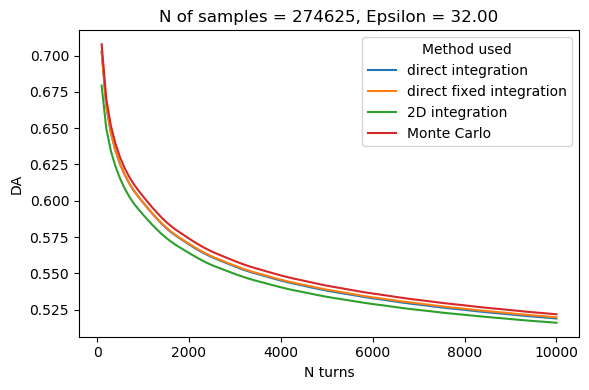

In [17]:
epsilon = epsilons[-1]
fineness = angle_sampling[-1]

plt.plot(turn_sampling, DA_1[(epsilon, fineness)], c="C0", label="direct integration")
plt.plot(turn_sampling, DA_2[(epsilon, fineness)], c="C1", label="direct fixed integration")
plt.plot(turn_sampling, DA_3[(epsilon, fineness**3)], c="C2", label="2D integration")
plt.plot(turn_sampling, DA_4[(epsilon, fineness**3)], c="C3", label="Monte Carlo")

plt.xlabel("N turns")
plt.ylabel("DA")
plt.legend(title="Method used")

plt.title("N of samples = {}, Epsilon = {:.2f}".format(fineness**3, epsilon))
plt.tight_layout()

### Saving a full comparison

In [24]:
for epsilon in epsilons:
    for fineness in angle_sampling:
        plt.plot(turn_sampling, DA_1[(epsilon, fineness)], c="C0", label="direct integration")
        plt.plot(turn_sampling, DA_2[(epsilon, fineness)], c="C1", label="direct fixed integration")
        plt.plot(turn_sampling, DA_3[(epsilon, fineness**3)], c="C2", label="2D integration")
        plt.plot(turn_sampling, DA_4[(epsilon, fineness**3)], c="C3", label="Monte Carlo")

        plt.xlabel("N turns")
        plt.ylabel("DA")
        plt.legend(title="Method used")

        plt.title("N of samples = {}, Epsilon = {:.2f}".format(fineness**3, epsilon))
        plt.tight_layout()
        plt.savefig("img/comparison_eps_{:.2f}_samp_{}.png".format(epsilon, fineness**3), dpi=300)
        plt.clf()

<Figure size 600x400 with 0 Axes>

### Method 1

In [26]:
for epsilon in epsilons:
    for i, fineness in enumerate(angle_sampling[:-1]):
        plt.plot(turn_sampling, DA_1[(epsilon, fineness)], c=color[i], label=fineness**3)

    plt.plot(turn_sampling, DA_1[(epsilon, angle_sampling[-1])], c="black", label="baseline ({})".format(angle_sampling[-1]**3))

    plt.xlabel("N turns")
    plt.ylabel("DA")
    plt.legend(fontsize="small", title="N of samples")

    plt.title("4D integration, Epsilon = {:.2f}".format(epsilon))
    plt.tight_layout()
    plt.savefig("img/4D_integration_eps_{:.2f}.png".format(epsilon), DPI=300)
    plt.clf()

<Figure size 600x400 with 0 Axes>

### Method 2

In [20]:
for epsilon in epsilons:
    for i, fineness in enumerate(angle_sampling**3):
        plt.plot(turn_sampling, DA_3[(epsilon, fineness)], c=color[i], label=fineness)

    plt.plot(turn_sampling, DA_1[(epsilon, angle_sampling[-1])], c="black", label="baseline ({})".format(angle_sampling[-1]**3))

    plt.xlabel("N turns")
    plt.ylabel("DA")
    plt.legend(fontsize="small", title="N of samples")

    plt.title("2D integration, Epsilon = {:.2f}".format(epsilon))
    plt.tight_layout()
    plt.savefig("img/2D_integration_eps_{:.2f}.png".format(epsilon), DPI=300)
    plt.clf()

<Figure size 600x400 with 0 Axes>

### Method 3

In [21]:
for epsilon in epsilons:
    for i, fineness in enumerate(angle_sampling**3):
        plt.plot(turn_sampling, DA_4[(epsilon, fineness)], c=color[i], label=fineness)

    plt.plot(turn_sampling, DA_1[(epsilon, angle_sampling[-1])], c="black", label="baseline ({})".format(angle_sampling[-1]**3))

    plt.xlabel("N turns")
    plt.ylabel("DA")
    plt.legend(fontsize="small", title="N of samples")

    plt.title("Montecarlo, Epsilon = {:.2f}".format(epsilon))
    plt.tight_layout()
    plt.savefig("img/montecarlo_eps_{:.2f}.png".format(epsilon), DPI=300)
    plt.clf()

<Figure size 600x400 with 0 Axes>

### Method 1 revised

In [25]:
for epsilon in epsilons:
    for i, fineness in enumerate(angle_sampling):
        plt.plot(turn_sampling, DA_2[(epsilon, fineness)], c=color[i], label=fineness**3)

    plt.plot(turn_sampling, DA_1[(epsilon, angle_sampling[-1])], c="black", label="baseline ({})".format(angle_sampling[-1]**3))

    plt.xlabel("N turns")
    plt.ylabel("DA")
    plt.legend(fontsize="small", title="N of samples")

    plt.title("4D integration (new method), Epsilon = {:.2f}".format(epsilon))
    plt.tight_layout()
    plt.savefig("img/4D_integration_new_eps_{:.2f}.png".format(epsilon), DPI=300)
    plt.clf()

<Figure size 600x400 with 0 Axes>